In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
from sklearn.pipeline import make_pipeline
from transforming import WithSelected, Calc, Apply

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# distributions overview
def distributions(X, *, cols, figsize=(6, 6), showstat=False, bins=None):
    columns = X.columns[~X.columns.isin(('id', 'target'))]
    rows = len(columns) // cols + bool(len(columns) % cols)

    fig, axis = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    for num, field in enumerate(columns):
        col = num % cols
        row = num // cols
        a = X.loc[X.target == 0, field]
        t = X.loc[X.target == 1, field]
        ax = axis[row, col] if rows > 1 else axis[col]

        ax.hist(a, edgecolor='black', alpha=0.7, bins=bins)
        ax.hist(t, edgecolor='black', alpha=0.7, bins=bins)
        if showstat:
            ax.axvline(X[field].mean(), color='green', label='common mean')
            ax.axvline(a.mean(), color='blue', label='0 (mean)')
            ax.axvline(t.mean(), color='purple', label='1 (mean)')

            ax.axvline(X[field].median(), ls='dashed', color='green', label='common median')
            ax.axvline(a.median(), ls='dashed', color='blue', label='0 (median)')
            ax.axvline(t.median(), ls='dashed', color='purple', label='1 (median)')
        ax.set_title(field)
    fig.legend(labels=['0', '1'] if not showstat else ['0', '1', 'common mean', '0 (mean)', '1 (mean)', 'common median', '0 (median)', '1 (median)'])
    fig.suptitle(f'Distributions by target')
    plt.show()

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
df.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [6]:
# classes balance
df.target.value_counts()

0    230
1    184
Name: target, dtype: int64

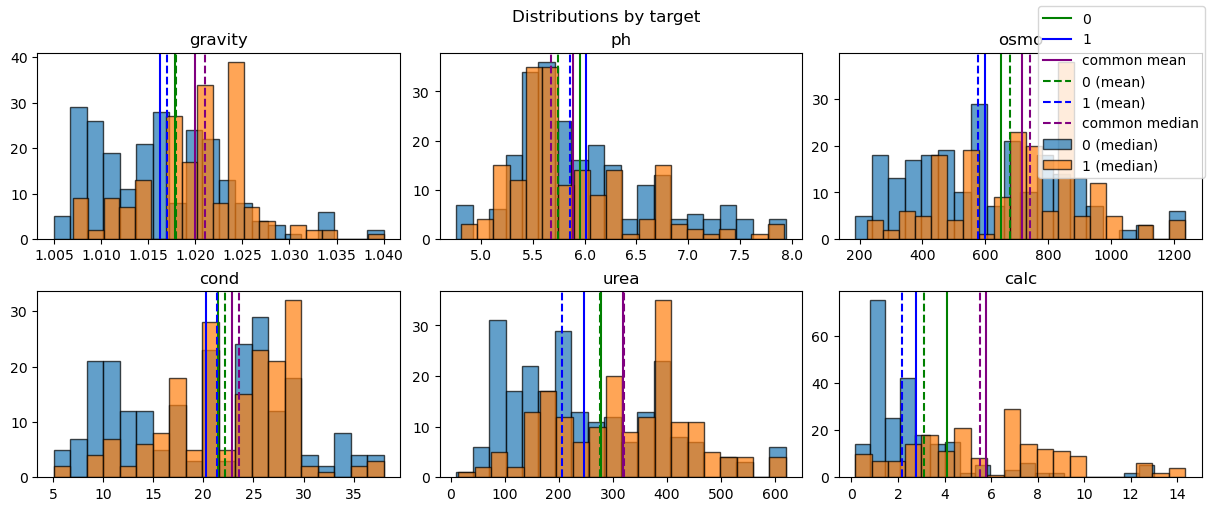

In [7]:
# distributions overview
distributions(df, cols=3, figsize=(12, 5), showstat=True, bins=20)

## preprocessing

In [15]:
original = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
pipe = make_pipeline(
    # is_norma features
    Calc('1*((1.008 < gravity) & (gravity < 1.030))', to='gravity_is_norma'),
    Calc('1*(urea <= 35)', to='urea_is_norma'),
    Calc('1*((2.5 < calc) & (calc < 7.5))', to='calc_is_norma'),

    # prod & ratio
    Calc('calc * urea * 10 ** (-ph)', to='ion_prod'),
    Calc('calc * urea / ph', to='ion_rate'),

    Calc('calc / urea', to='calc_urea_rate'),
    Calc('calc / ph', to='calc_ph_rate'),

    Calc('osmo / gravity', to='osmo_gravity_rate'),
    Calc('osmo / ph', to='osmo_ph_rate'),
    Calc('gravity / ph', to='gravity_ph_rate'),
    Calc('gravity / calc', to='gravity_calc_rate'),
    Calc('cond / ph', to='cond_ph_rate'),
    Calc('cond / calc', to='cond_calc_rate'),
    Calc('cond / urea', to='cond_urea_rate'),

    Calc('(osmo * gravity) / (cond * ph)', to='osmo_gravity_prod_cond_ph_prod_rate'),
    Calc('cond / (urea * calc)', to='cond_(urea_calc_prod)_rate'),

    # pH-like
    Calc('-np.log10(calc * 10e-6)', to='pCalc'),
    Calc('-np.log10(urea * 10e-6)', to='pUr'),
    Calc('-np.log10(osmo * 10e-6)', to='pOs'),
    Calc('-np.log10(cond * 10e-6)', to='pCond'),
    
    # Calc('pCalc - ph', to='pCalc_ph_diff'),
    # Calc('pUr - ph', to='pUr_ph_diff'),

    # Calc('', to=''),
    # Calc('', to=''),

    # power
    WithSelected(None, 'pow')(
    # WithSelected(original, 'pow')(
        pre.PowerTransformer()
    ),
    # categirues/binaries
    WithSelected(original, suffix='bins')(
    # WithSelected(lambda columns: [col for col in columns if 'norma' not in col and 'pow' not in col], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='ordinal', strategy='kmeans')
    ),
    # analysis
    Apply(
        # estimator=LinearDiscriminantAnalysis(),
        # locpipe=pre.Normalizer(),
        estimator=LinearDiscriminantAnalysis(solver='lsqr'),
        locpipe=pre.StandardScaler(),
        # on=lambda columns: [col for col in columns if 'pow' in col],
        to='lda',
        as_proba=True
    ),
    Apply(
        estimator=KNeighborsClassifier(7, leaf_size=30, n_jobs=-1),
        to='neighbours',
        as_proba=True
    ),
    # Apply(
    #     estimator=IsolationForest(n_estimators=10, max_samples='auto', warm_start=True, bootstrap=True, n_jobs=-1, random_state=17),
    #     locpipe=pre.Normalizer(),
    #     to='isolation'
    # ),
    # calculations with generated features
    Calc('neighbours / calc', to='ngb_calc_rate'),
    Calc('lda / calc', to='lda_calc_rate'),
    Calc('neighbours / ph', to='ngb_ph_rate'),
    Calc('lda / ph', to='lda_ph_rate'),
    Calc('neighbours / gravity', to='ngb_gravity_rate'),
    Calc('lda / gravity', to='lda_gravity_rate'),
    # Calc('neighbours / lda', to='ngb_lda_rate'),
    Calc('(osmo / gravity) * lda', to='osmo_gravity_rate_lda_weighted'),

    Calc('(calc * urea / ph) * lda', to='ion_lda_prod'),
    Calc('(calc * urea / ph) * neighbours', to='ion_ngb_prod'),
    # Calc('gravity_calc_rate * lda', to='gravity_calc_rate_lda_prod'),
    # Calc('gravity_calc_rate * neighbours', to='gravity_calc_rate_ngb_prod'),

    # Select(original, mode='drop'),
)

X = pipe.fit_transform(df[original], df.target)
X['target'] = df.target
X.head()

,gravity,ph,osmo,cond,urea,calc,gravity_is_norma,urea_is_norma,calc_is_norma,ion_prod,...,ngb_calc_rate,lda_calc_rate,ngb_ph_rate,lda_ph_rate,ngb_gravity_rate,lda_gravity_rate,osmo_gravity_rate_lda_weighted,ion_lda_prod,ion_ngb_prod,target
0,1.013,6.19,443,14.8,124,1.45,1,0,0,0.000116,...,0.197044,0.036734,0.046157,0.008605,0.282048,0.052580,23.293134,1.547151,8.299100,0
1,1.025,5.40,703,23.6,394,4.18,1,0,1,0.006557,...,0.136705,0.124513,0.105820,0.096382,0.557491,0.507769,356.961409,158.733485,174.277249,0
2,1.009,6.13,371,24.5,159,9.04,1,0,0,0.001066,...,0.079014,0.099952,0.116523,0.147401,0.707914,0.895506,332.232636,211.867640,167.485435,0
3,1.021,4.91,442,20.8,398,6.63,1,0,1,0.032464,...,0.107735,0.130364,0.145476,0.176031,0.699594,0.846534,374.168099,464.499594,383.872563,1
4,1.021,5.53,874,17.8,385,2.21,1,0,0,0.002511,...,0.193924,0.150753,0.077499,0.060247,0.419757,0.326312,285.196522,51.260921,65.940325,1


In [10]:
# fast overview
# distributions(X[['', 'target']], cols=2, figsize=(10,3))

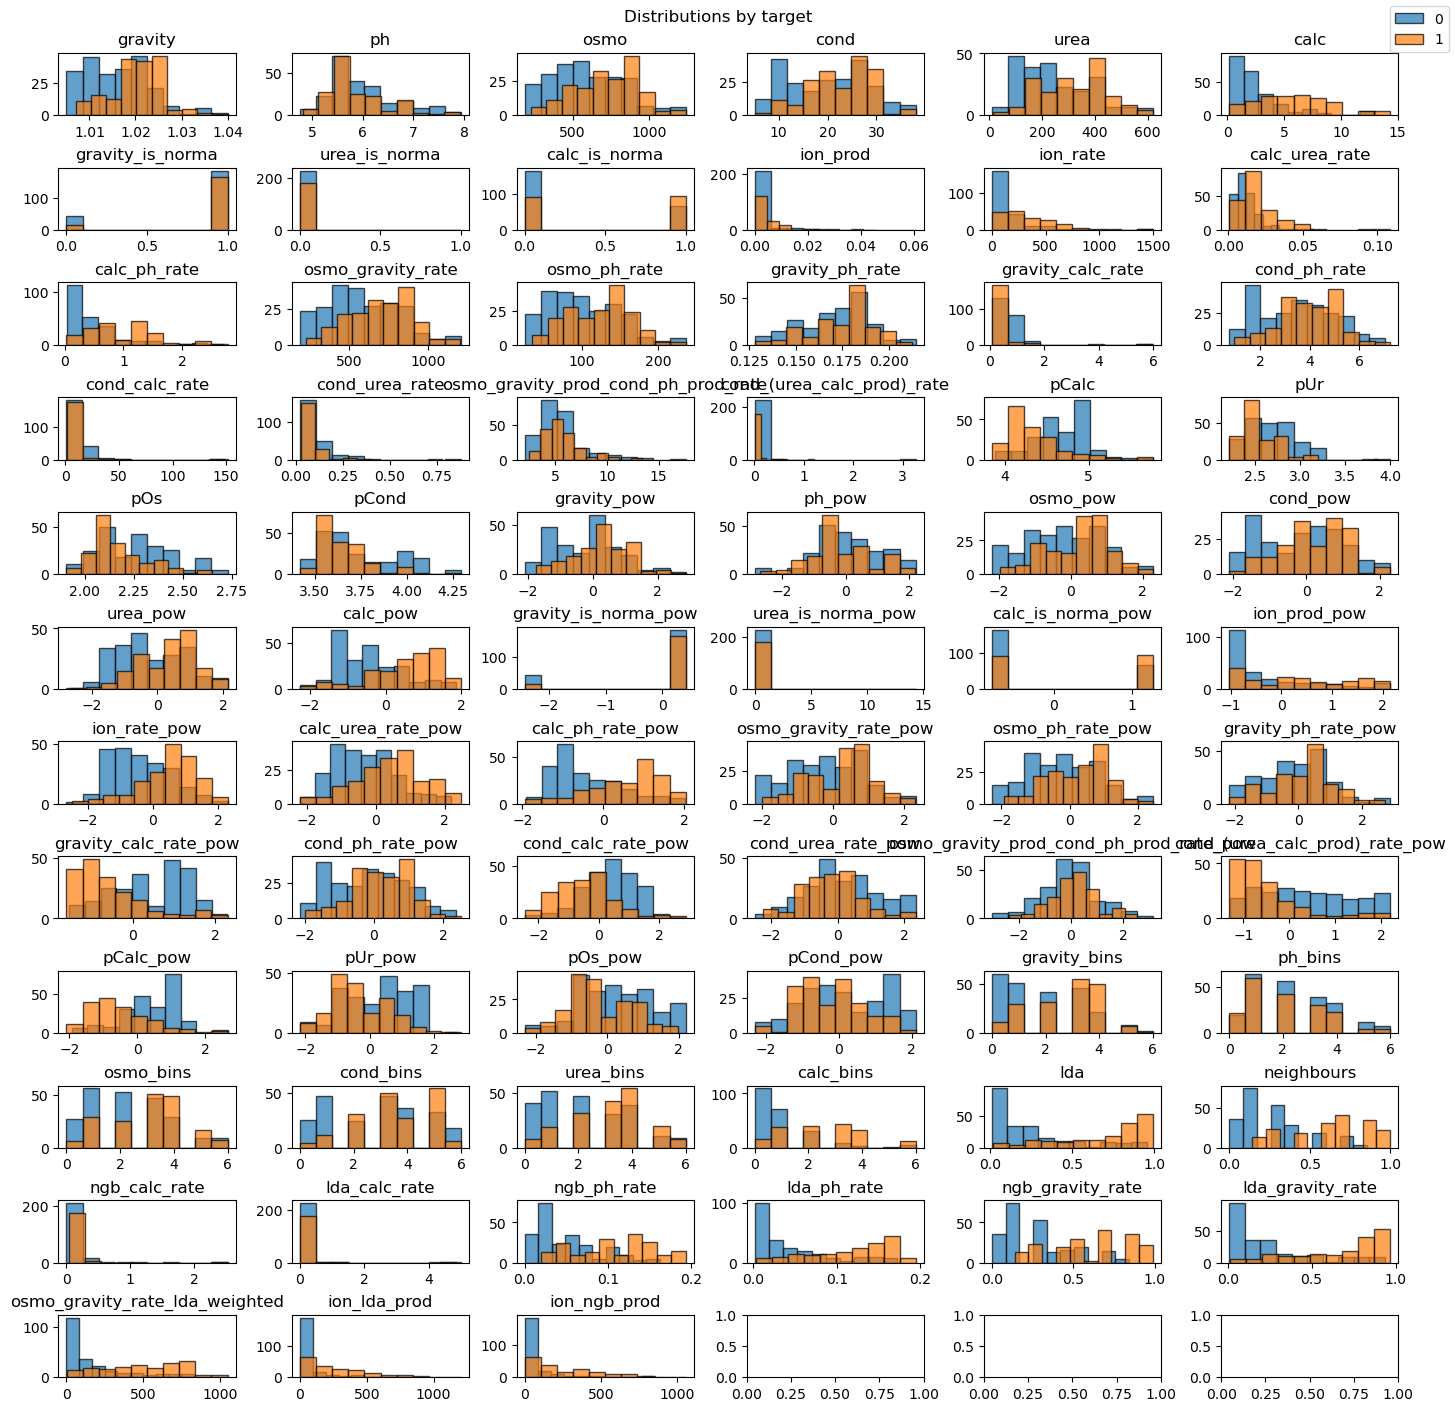

In [16]:
# target Bins by target distributions
distributions(X, cols=6, figsize=(14,14))

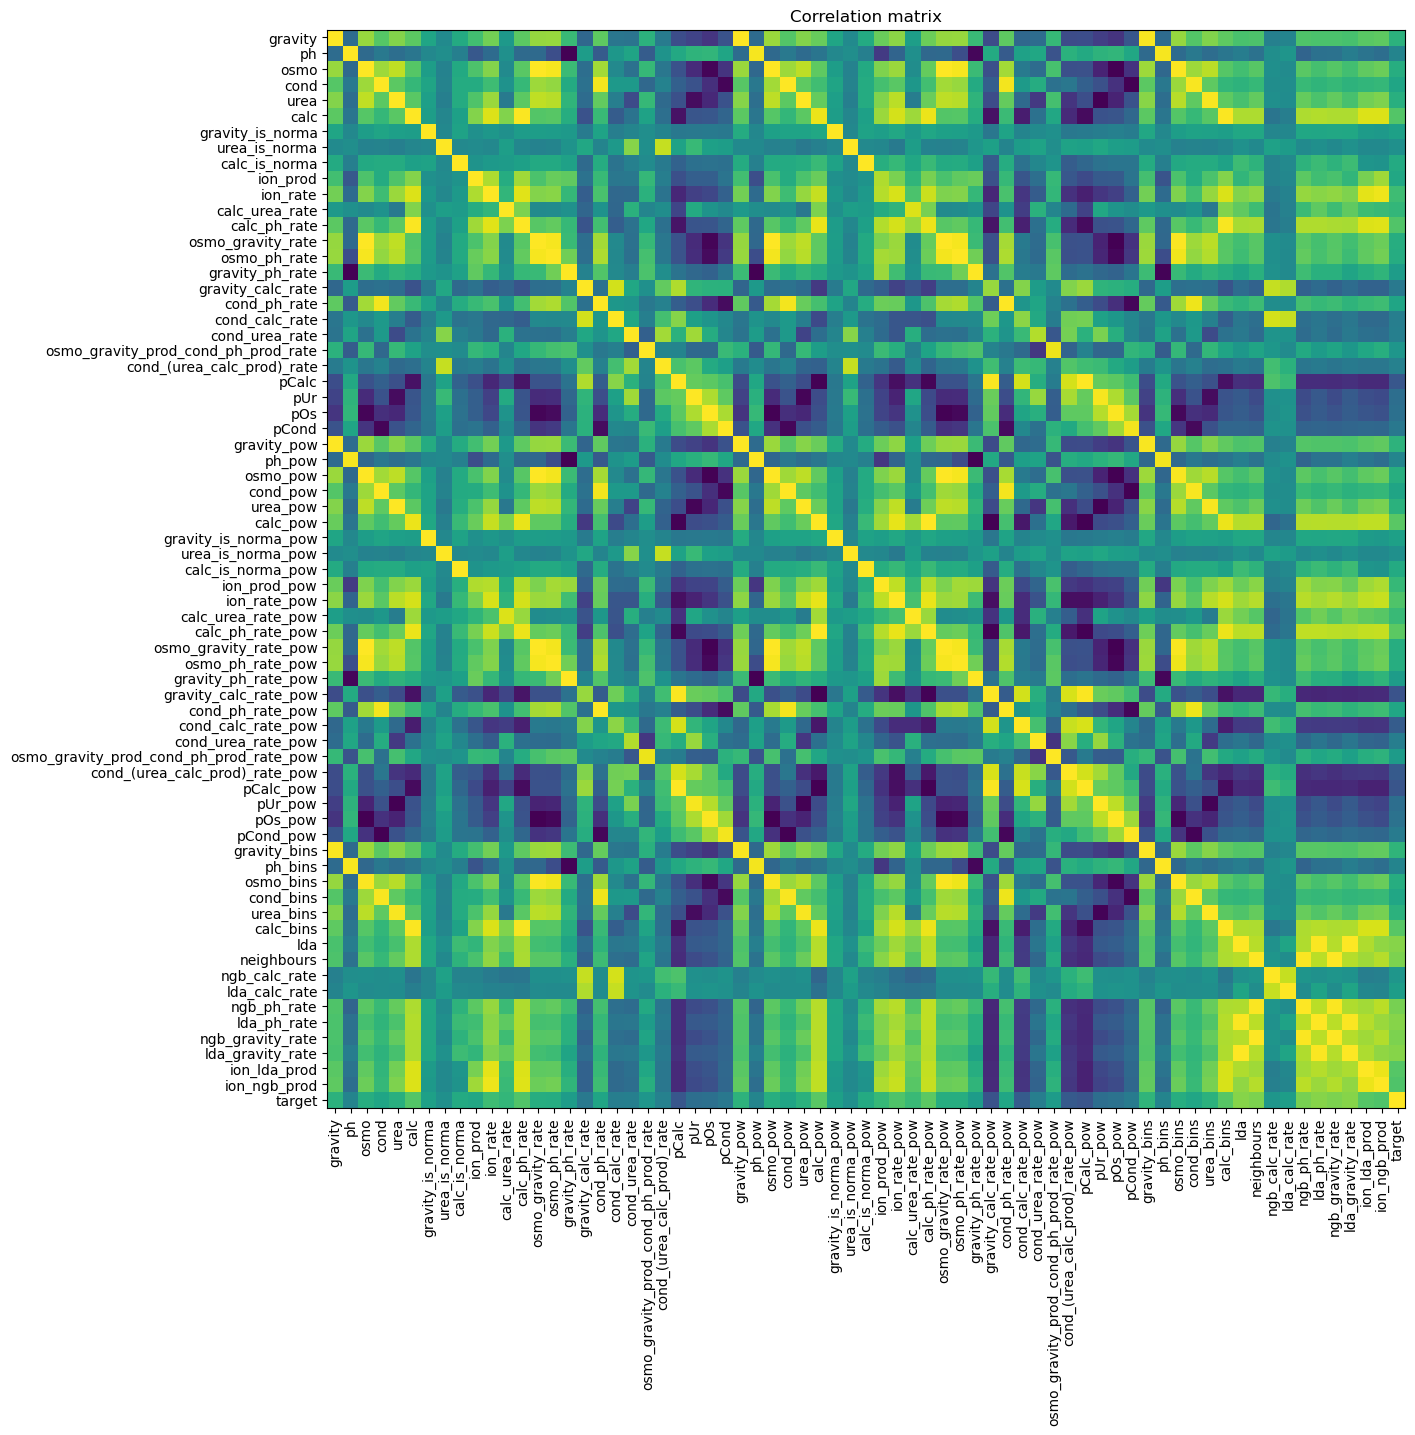

In [14]:
# correlation
plt.figure(figsize=(14, 14))
plt.title('Correlation matrix')
plt.xticks(ticks=range(X.columns.size), labels=X.columns, rotation=90)
plt.yticks(ticks=range(X.columns.size), labels=X.columns)
plt.imshow(X.corr());

In [ ]:
#